In [16]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


STEP 1: Please upload your transactions.json file


Saving user-wallet-transactions.json to user-wallet-transactions (1).json

✓ File 'user-wallet-transactions (1).json' uploaded (87.0 MB)

STEP 2: Loading MongoDB-style JSON data...
✓ Loaded 100000 transactions

STEP 3: Preparing data...

STEP 4: Performing EDA...

[1] Transaction Overview:
• Total transactions: 100,000
• Unique wallets: 3,497
• Time period: 2021-03-31 to 2021-09-02

[2] Transaction Types:


,count
type,
deposit,37808
redeem,32305
borrow,17086
repay,12553
liquidation,248


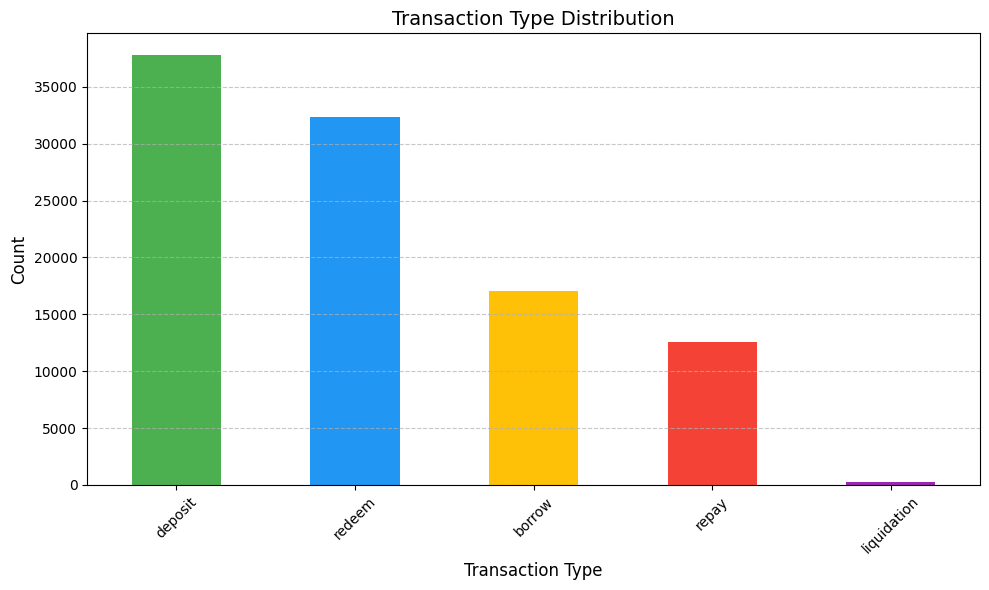


[3] Missing Values Analysis:


,0
asset,248



[4] Asset Distribution:


,count
asset,
USDC,29673
DAI,17689
USDT,16019
WETH,11619
WPOL,9254
WMATIC,9051
WBTC,4178
AAVE,2269


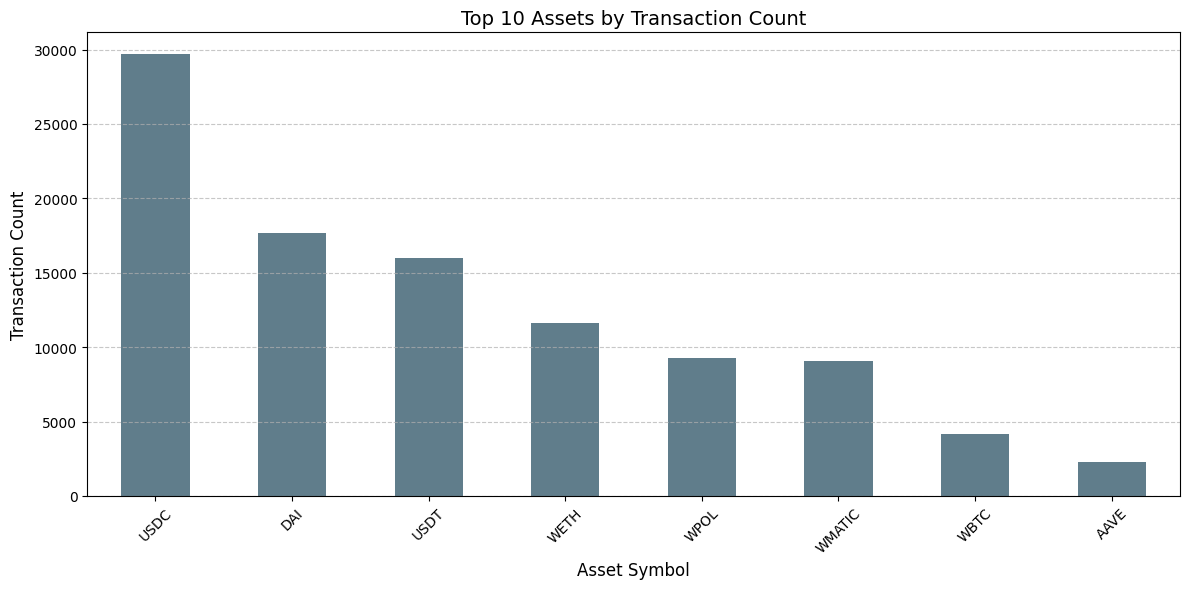


[5] Amount Statistics:


,amount
count,"100,000.00"
mean,"6,544,794,942,323,561,594,880.00"
std,"126,493,472,815,235,454,730,240.00"
min,0.00
25%,"234,700,775.75"
50%,"520,443,998,987.50"
75%,"24,999,729,577,545,179,136.00"
max,"12,730,000,000,000,000,532,676,608.00"


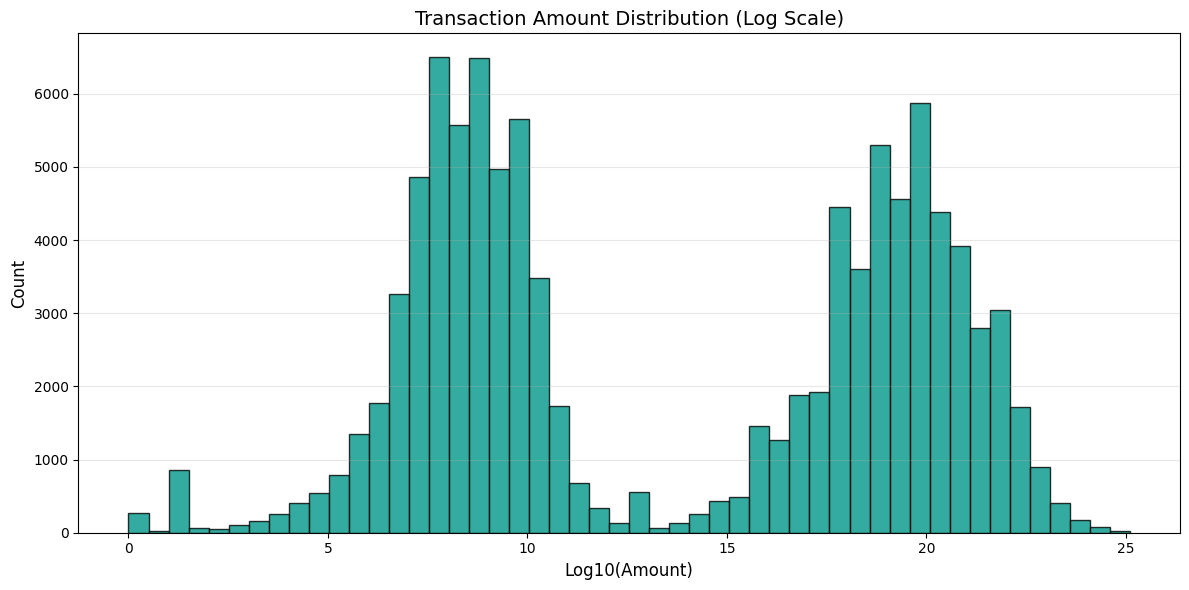


[6] Temporal Patterns:


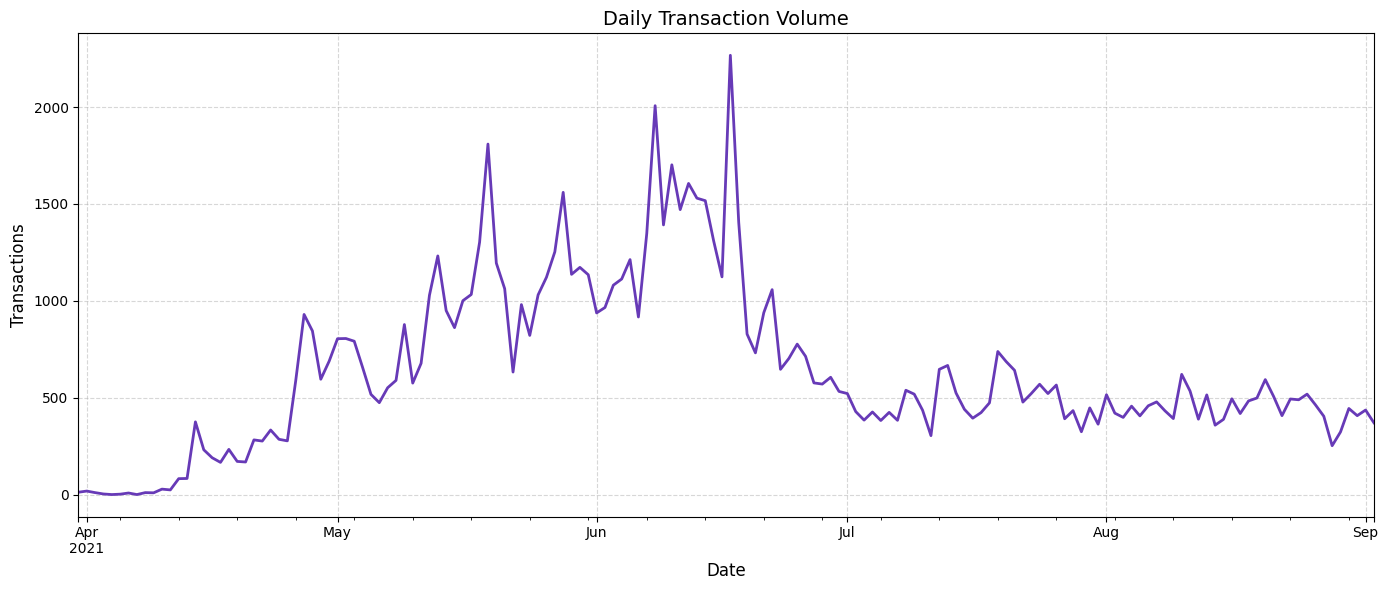


[7] User Behavior Analysis:
• Avg transactions per user: 28.60
• Most active user: 0x05c9db563db8e38cc2899297da41ce430b61a484 (14265 transactions)


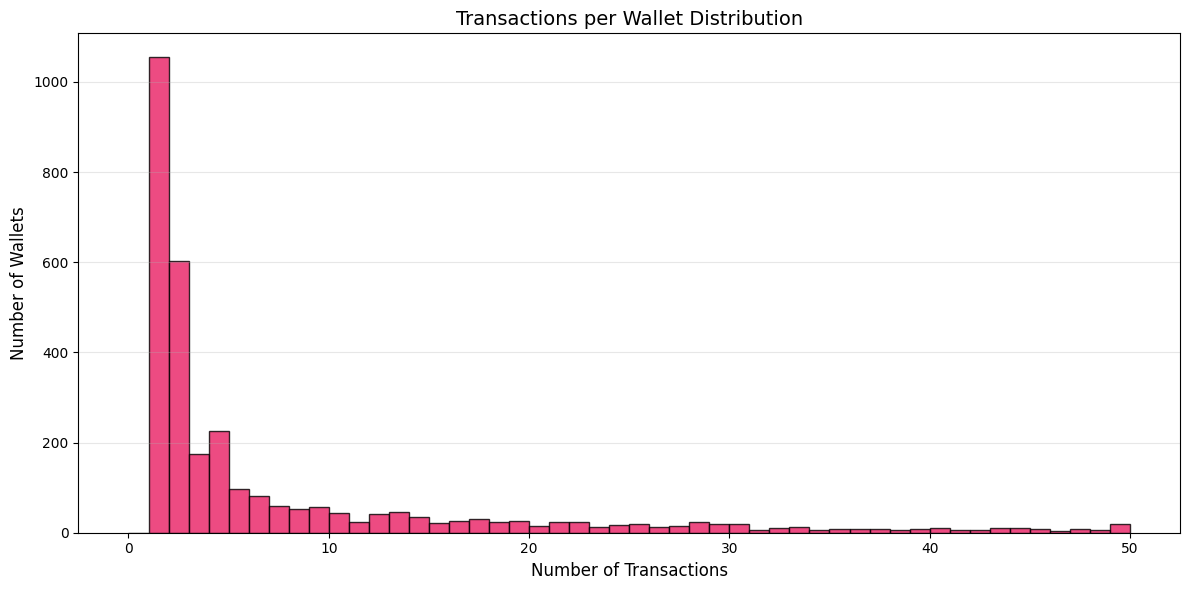


✓ EDA Complete!


In [23]:
# -*- coding: utf-8 -*-
"""Aave_V2_Wallet_Credit_Scoring_EDA.ipynb

Automatically generated by Colaboratory.
"""

# ======================
# 1. SETUP & DATA LOADING
# ======================

!pip install pandas numpy matplotlib --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io
import json
from datetime import datetime

# ----------------------
# FILE UPLOAD (FROM PC)
# ----------------------
print("STEP 1: Please upload your transactions.json file")
uploaded = files.upload()
file_name = next(iter(uploaded))
file_size = len(uploaded[file_name])/1024/1024
print(f"\n✓ File '{file_name}' uploaded ({file_size:.1f} MB)")

# ======================
# 2. MONGODB JSON LOADER
# ======================

def load_mongodb_json(uploaded_file, file_name):
    """
    Specialized loader for MongoDB JSON format
    """
    print("\nSTEP 2: Loading MongoDB-style JSON data...")
    file_content = uploaded_file[file_name].decode('utf-8')

    # Clean and prepare the JSON data
    if file_content.startswith('['):
        # It's a JSON array
        json_data = json.loads(file_content)
    else:
        # It's JSON objects separated by commas
        json_data = json.loads(f"[{file_content}]")

    print(f"✓ Loaded {len(json_data)} transactions")
    return pd.json_normalize(json_data)

# Load data
df = load_mongodb_json(uploaded, file_name)

# ======================
# 3. DATA PREPARATION
# ======================

print("\nSTEP 3: Preparing data...")

# 1. Rename columns to standard names
column_mapping = {
    'userWallet': 'user',
    'action': 'type',
    'actionData.amount': 'amount',
    'actionData.assetSymbol': 'asset',
    'timestamp': 'timestamp'
}
df = df.rename(columns=column_mapping)

# 2. Convert data types
df['amount'] = pd.to_numeric(df['amount'], errors='coerce')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# 3. Filter and clean
df = df[['user', 'type', 'amount', 'asset', 'timestamp']].copy()
df = df.dropna(subset=['user', 'type', 'amount'])

# Convert any empty strings to NaN in relevant string columns
string_cols = ['user', 'type', 'asset']
df[string_cols] = df[string_cols].replace('', np.nan)

# ======================
# 4. EXPLORATORY ANALYSIS
# ======================

print("\nSTEP 4: Performing EDA...")

# ----------------------
# 4.1 BASIC STATS
# ----------------------
print("\n[1] Transaction Overview:")
print(f"• Total transactions: {len(df):,}")
print(f"• Unique wallets: {df['user'].nunique():,}")
print(f"• Time period: {df['timestamp'].min().strftime('%Y-%m-%d')} to {df['timestamp'].max().strftime('%Y-%m-%d')}")

# ----------------------
# 4.2 TRANSACTION TYPES
# ----------------------
print("\n[2] Transaction Types:")
type_mapping = {
    'deposit': 'deposit',
    'borrow': 'borrow',
    'repay': 'repay',
    'liquidationcall': 'liquidation',
    'redeemunderlying': 'redeem'
}
df['type'] = df['type'].str.lower().map(type_mapping).fillna('other')

tx_counts = df['type'].value_counts()
display(tx_counts)

plt.figure(figsize=(10, 6))
tx_counts.plot(kind='bar', color=['#4CAF50', '#2196F3', '#FFC107', '#F44336', '#9C27B0'])
plt.title('Transaction Type Distribution', fontsize=14)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Transaction Type', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ----------------------
# 4.3 MISSING VALUES
# ----------------------
print("\n[3] Missing Values Analysis:")
missing = df.isnull().sum()
display(missing[missing > 0])

# ----------------------
# 4.4 ASSET ANALYSIS
# ----------------------
print("\n[4] Asset Distribution:")
top_assets = df['asset'].value_counts().head(10)
display(top_assets)

plt.figure(figsize=(12, 6))
top_assets.plot(kind='bar', color='#607D8B')
plt.title('Top 10 Assets by Transaction Count', fontsize=14)
plt.ylabel('Transaction Count', fontsize=12)
plt.xlabel('Asset Symbol', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ----------------------
# 4.5 AMOUNT ANALYSIS
# ----------------------
print("\n[5] Amount Statistics:")
display(df['amount'].describe().apply(lambda x: f"{x:,.2f}"))

# Plot amount distribution
plt.figure(figsize=(12, 6))
plt.hist(np.log10(df['amount'] + 1), bins=50, color='#009688', edgecolor='black', alpha=0.8)
plt.title('Transaction Amount Distribution (Log Scale)', fontsize=14)
plt.xlabel('Log10(Amount)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# ----------------------
# 4.6 TEMPORAL ANALYSIS
# ----------------------
print("\n[6] Temporal Patterns:")

# Resample to daily frequency
daily_txs = df.set_index('timestamp').resample('D').size()

plt.figure(figsize=(14, 6))
daily_txs.plot(color='#673AB7', linewidth=2)
plt.title('Daily Transaction Volume', fontsize=14)
plt.ylabel('Transactions', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ----------------------
# 4.7 USER BEHAVIOR
# ----------------------
print("\n[7] User Behavior Analysis:")

# Calculate transactions per user
txs_per_user = df['user'].value_counts()
print(f"• Avg transactions per user: {txs_per_user.mean():.2f}")
print(f"• Most active user: {txs_per_user.idxmax()} ({txs_per_user.max()} transactions)")

plt.figure(figsize=(12, 6))
plt.hist(txs_per_user, bins=50, range=(0, 50), color='#E91E63', edgecolor='black', alpha=0.8)
plt.title('Transactions per Wallet Distribution', fontsize=14)
plt.xlabel('Number of Transactions', fontsize=12)
plt.ylabel('Number of Wallets', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ EDA Complete!")

In [18]:
import pandas as pd

# Load JSON data
df = pd.read_json("transactions.json")  # Replace with actual path


In [24]:
# Now check for missing values again
print("\n🔍 Rechecking for missing string values:")
print(df[string_cols].isnull().sum())


🔍 Rechecking for missing string values:
user       0
type       0
asset    248
dtype: int64


In [25]:
df = df.dropna(subset=['asset'])
print(f"✓ Dropped rows with missing asset. New shape: {df.shape}")

✓ Dropped rows with missing asset. New shape: (99752, 5)


In [26]:
# Descriptive stats
print("\n🔍 Raw 'amount' column stats:")
print(df['amount'].describe().apply(lambda x: f"{x:,.2f}"))

# Count extreme outliers
high_thresh = 1e22  # You can fine-tune this threshold
extreme_outliers = df[df['amount'] > high_thresh]
print(f"\n⚠️ {len(extreme_outliers)} transactions exceed 10^22 in amount.")



🔍 Raw 'amount' column stats:
count                                99,752.00
mean          6,561,066,386,963,231,145,984.00
std         126,650,197,173,255,467,433,984.00
min                                       1.00
25%                             247,420,270.00
50%                         844,651,096,533.50
75%              25,000,000,000,000,000,000.00
max      12,730,000,000,000,000,532,676,608.00
Name: amount, dtype: object

⚠️ 3722 transactions exceed 10^22 in amount.


In [27]:
# Clip at 99th percentile
q99 = df['amount'].quantile(0.99)
df['amount_clipped'] = np.minimum(df['amount'], q99)

print(f"🔧 Clipped values above the 99th percentile: {q99:,.2f}")


🔧 Clipped values above the 99th percentile: 75,000,000,000,000,002,097,152.00


In [28]:
df['log_amount'] = np.log10(df['amount_clipped'] + 1)


/tmp/ipython-input-29-1134844418.py:8: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


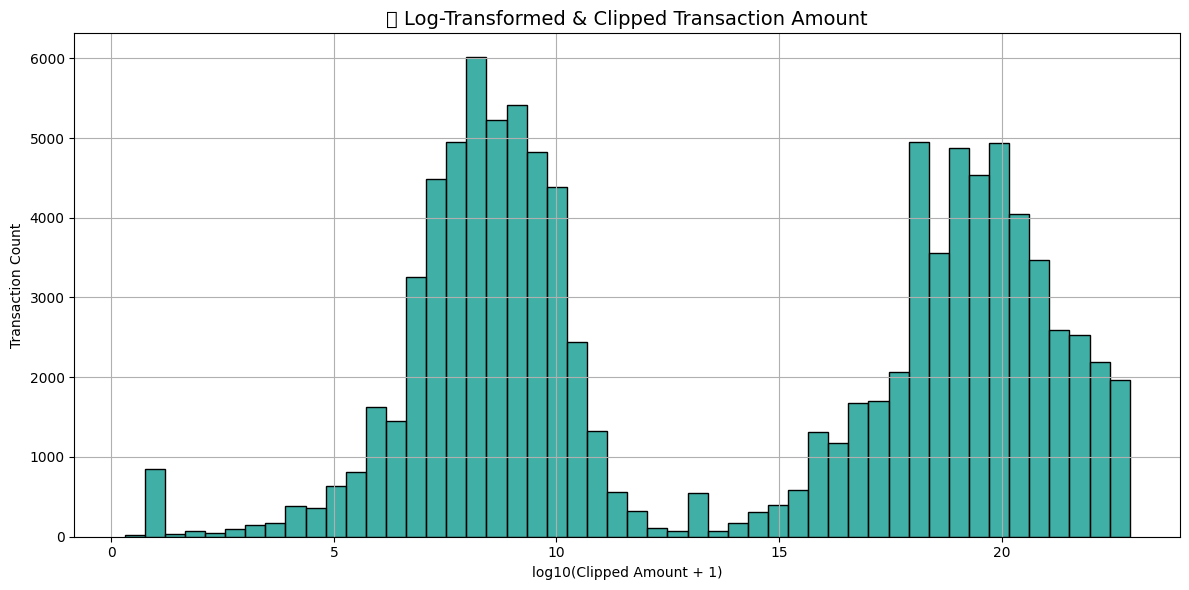

In [29]:
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.histplot(df['log_amount'], bins=50, color='#009688')
plt.title("✅ Log-Transformed & Clipped Transaction Amount", fontsize=14)
plt.xlabel("log10(Clipped Amount + 1)")
plt.ylabel("Transaction Count")
plt.grid(True)
plt.tight_layout()
plt.show()


Detect High Volume / Bot-like Wallets

In [30]:
wallet_activity = df.groupby('user').size().reset_index(name='tx_count')
df = df.merge(wallet_activity, on='user')
df['bot_suspect'] = df['tx_count'] > 1000  # or another threshold


Visual Insight: Top Transaction Types

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


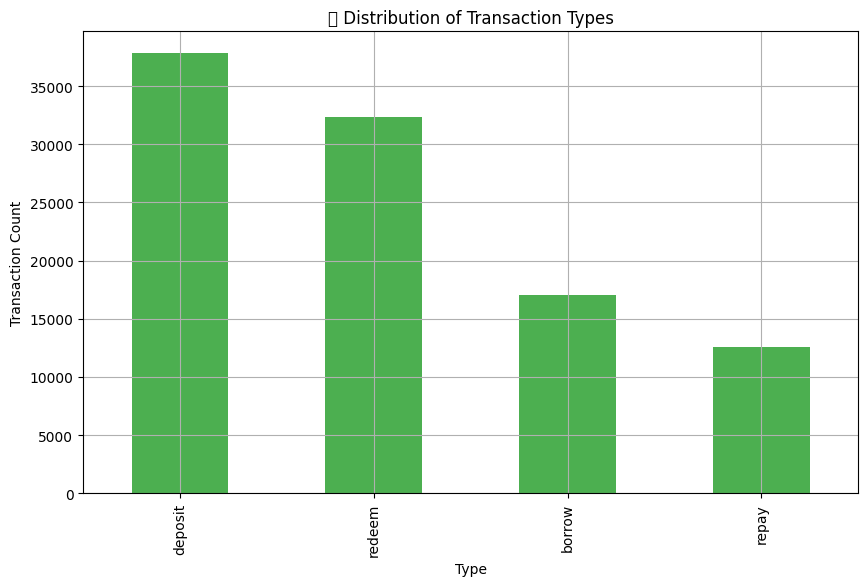

In [31]:
plt.figure(figsize=(10,6))
df['type'].value_counts().plot(kind='bar', color='#4CAF50')
plt.title("📊 Distribution of Transaction Types")
plt.xlabel("Type")
plt.ylabel("Transaction Count")
plt.grid(True)
plt.show()



 Normalize Strings (Asset, User, Type)


In [32]:
for col in ['user', 'type', 'asset']:
    df[col] = df[col].astype(str).str.strip().str.lower()

Feature Engineering Blueprint:


In [33]:
# Ensure 'timestamp' is in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# ---------------------------
# 1. Total Deposits & Borrows
# ---------------------------
total_deposits = df[df['type'] == 'deposit'].groupby('user').size().rename('total_deposits')
total_borrows = df[df['type'] == 'borrow'].groupby('user').size().rename('total_borrows')

# ---------------------------
# 2. Repay-to-Borrow Ratio
# ---------------------------
borrow_sum = df[df['type'] == 'borrow'].groupby('user')['amount'].sum().rename('total_borrow_amount')
repay_sum = df[df['type'] == 'repay'].groupby('user')['amount'].sum().rename('total_repay_amount')
repay_to_borrow_ratio = (repay_sum / (borrow_sum + 1)).rename('repay_to_borrow_ratio')  # Prevent divide-by-zero

# ---------------------------
# 3. Average Borrow-Repay Time
# ---------------------------
borrow_df = df[df['type'] == 'borrow'][['user', 'timestamp']].rename(columns={'timestamp': 'borrow_time'})
repay_df = df[df['type'] == 'repay'][['user', 'timestamp']].rename(columns={'timestamp': 'repay_time'})

# Merge by user (simple inner join)
merged = pd.merge(borrow_df, repay_df, on='user')

# Take absolute time delta to avoid negative durations
merged['delta'] = (merged['repay_time'] - merged['borrow_time']).dt.total_seconds().abs()

# Calculate avg borrow–repay time
avg_borrow_repay_time = merged.groupby('user')['delta'].mean().rename('avg_borrow_repay_time')

# ---------------------------
# 4. Liquidation Count
# ---------------------------
liquidation_count = df[df['type'] == 'liquidationcall'].groupby('user').size().rename('liquidation_count')

# ---------------------------
# 5. Active Days
# ---------------------------
first_seen = df.groupby('user')['timestamp'].min()
last_seen = df.groupby('user')['timestamp'].max()
active_days = (last_seen - first_seen).dt.days.rename('active_days')

# ---------------------------
# 6. Tx Frequency = total_tx / active_days
# ---------------------------
tx_count = df.groupby('user').size().rename('total_tx')
tx_frequency = (tx_count / (active_days + 1)).rename('tx_frequency')  # +1 for stability

# ---------------------------
# 7. Unique Transaction Types
# ---------------------------
unique_tx_types = df.groupby('user')['type'].nunique().rename('unique_tx_types')

# ---------------------------
# 8. Final Feature Matrix
# ---------------------------
features = pd.concat([
    total_deposits,
    total_borrows,
    repay_to_borrow_ratio,
    avg_borrow_repay_time,
    liquidation_count,
    active_days,
    tx_frequency,
    unique_tx_types
], axis=1).fillna(0)

# Display sample
features.head()


,total_deposits,total_borrows,repay_to_borrow_ratio,avg_borrow_repay_time,liquidation_count,active_days,tx_frequency,unique_tx_types
user,,,,,,,,
0x00000000001accfa9cef68cf5371a23025b6d4b6,1.0,0.0,0.000000e+00,0.000000e+00,0.0,0,1.000,1
0x000000000051d07a4fb3bd10121a343d85818da6,1.0,0.0,0.000000e+00,0.000000e+00,0.0,0,1.000,1
0x000000000096026fb41fc39f9875d164bd82e2dc,2.0,0.0,0.000000e+00,0.000000e+00,0.0,7,0.250,1
0x0000000002032370b971dabd36d72f3e5a7bf1ee,250.0,15.0,1.774571e-12,1.670558e+06,0.0,132,3.000,4
0x000000000a38444e0a6e37d3b630d7e855a7cb13,7.0,8.0,1.000745e+00,1.726246e+06,0.0,39,0.625,4


In [34]:
from sklearn.preprocessing import MinMaxScaler

# -----------------------
# Normalize Wallet Features
# -----------------------
scaler = MinMaxScaler()
scaled_features = pd.DataFrame(
    scaler.fit_transform(features),
    columns=features.columns,
    index=features.index
)

scaled_features.head()


,total_deposits,total_borrows,repay_to_borrow_ratio,avg_borrow_repay_time,liquidation_count,active_days,tx_frequency,unique_tx_types
user,,,,,,,,
0x00000000001accfa9cef68cf5371a23025b6d4b6,0.001957,0.000,0.000000e+00,0.000000,0.0,0.000000,0.004531,0.0
0x000000000051d07a4fb3bd10121a343d85818da6,0.001957,0.000,0.000000e+00,0.000000,0.0,0.000000,0.004531,0.0
0x000000000096026fb41fc39f9875d164bd82e2dc,0.003914,0.000,0.000000e+00,0.000000,0.0,0.045752,0.001060,0.0
0x0000000002032370b971dabd36d72f3e5a7bf1ee,0.489237,0.075,8.823042e-13,0.174572,0.0,0.862745,0.013785,1.0
0x000000000a38444e0a6e37d3b630d7e855a7cb13,0.013699,0.040,4.975633e-01,0.180391,0.0,0.254902,0.002796,1.0


In [35]:
from sklearn.preprocessing import MinMaxScaler

# ----------------------------
# Heuristic Credit Score Calculation
# ----------------------------

# Define heuristic weights (positive = reward, negative = penalty)
heuristic_weights = {
    'total_deposits': 100,
    'total_borrows': 50,
    'repay_to_borrow_ratio': 200,
    'avg_borrow_repay_time': 100,
    'liquidation_count': -200,
    'active_days': 100,
    'tx_frequency': -50,
    'unique_tx_types': 50
}

# Create a copy to apply weights
rule_score_df = scaled_features.copy()

# Apply weights
for col, weight in heuristic_weights.items():
    rule_score_df[col] = rule_score_df[col] * weight

# Sum all features to get the raw score
rule_score_df['raw_score'] = rule_score_df.sum(axis=1)

# Normalize to 0–1000
scaler = MinMaxScaler()
rule_score_df['credit_score'] = scaler.fit_transform(rule_score_df[['raw_score']]) * 1000
rule_score_df['credit_score'] = rule_score_df['credit_score'].round(2)

# Final result
credit_scores = rule_score_df[['credit_score']]
credit_scores.head()


,credit_score
user,
0x00000000001accfa9cef68cf5371a23025b6d4b6,22.37
0x000000000051d07a4fb3bd10121a343d85818da6,22.37
0x000000000096026fb41fc39f9875d164bd82e2dc,36.37
0x0000000002032370b971dabd36d72f3e5a7bf1ee,604.82
0x000000000a38444e0a6e37d3b630d7e855a7cb13,578.08


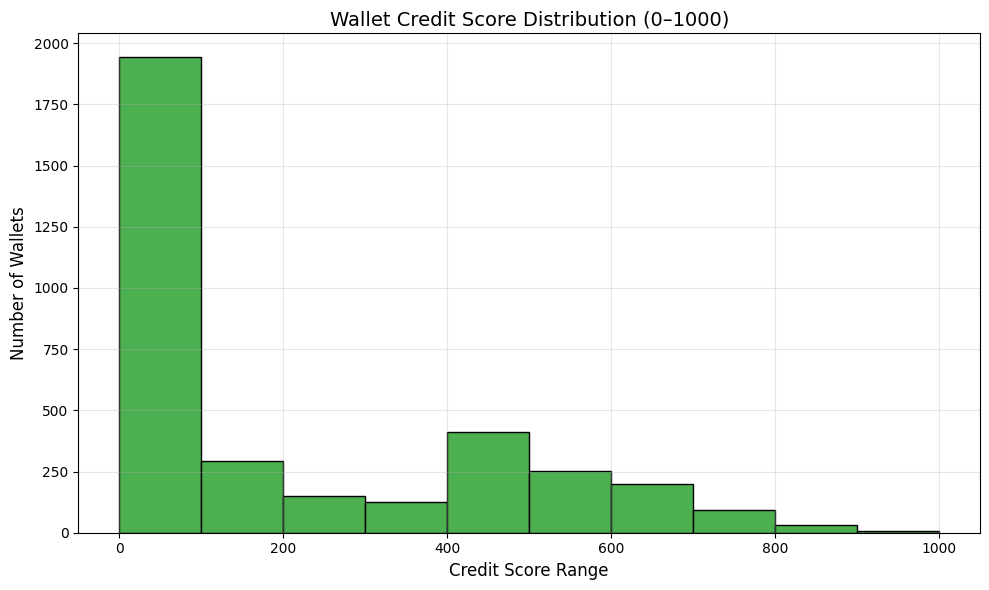

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(credit_scores['credit_score'], bins=10, color='#4CAF50', edgecolor='black')
plt.title('Wallet Credit Score Distribution (0–1000)', fontsize=14)
plt.xlabel('Credit Score Range', fontsize=12)
plt.ylabel('Number of Wallets', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


/tmp/ipython-input-37-3916463135.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_scores['risk_band'] = credit_scores['credit_score'].apply(categorize_score)


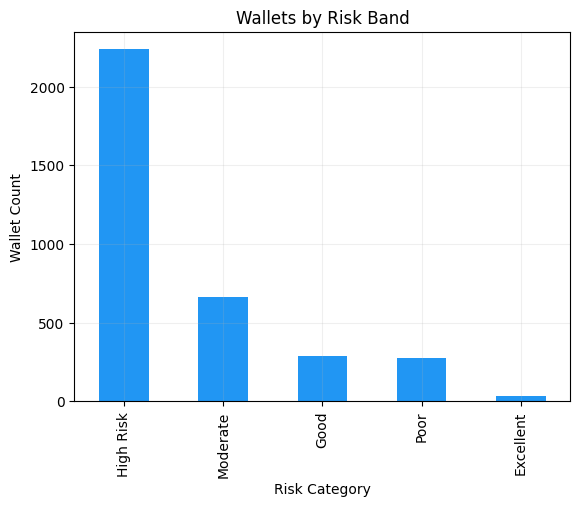

In [37]:
def categorize_score(score):
    if score >= 800:
        return 'Excellent'
    elif score >= 600:
        return 'Good'
    elif score >= 400:
        return 'Moderate'
    elif score >= 200:
        return 'Poor'
    else:
        return 'High Risk'

credit_scores['risk_band'] = credit_scores['credit_score'].apply(categorize_score)

# Show distribution by band
credit_scores['risk_band'].value_counts().plot(kind='bar', color='#2196F3')
plt.title('Wallets by Risk Band')
plt.xlabel('Risk Category')
plt.ylabel('Wallet Count')
plt.grid(True, alpha=0.2)
plt.show()


In [38]:
from sklearn.preprocessing import MinMaxScaler

# Apply MinMaxScaler across all feature columns
scaler = MinMaxScaler()
normalized_features = pd.DataFrame(
    scaler.fit_transform(features),
    columns=features.columns,
    index=features.index
)

# Assign weights to each feature (you can tweak this later)
weights = {
    'total_deposits': 0.15,
    'total_borrows': 0.10,
    'repay_to_borrow_ratio': 0.25,
    'avg_borrow_repay_time': 0.15,
    'liquidation_count': -0.25,
    'active_days': 0.10,
    'tx_frequency': -0.10,
    'unique_tx_types': 0.10
}

# Weighted sum
credit_score = normalized_features.mul(pd.Series(weights)).sum(axis=1)

# Normalize to 0–1000
credit_score = MinMaxScaler(feature_range=(0, 1000)).fit_transform(credit_score.values.reshape(-1, 1)).flatten()

# Add credit_score to features
features['credit_score'] = credit_score


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


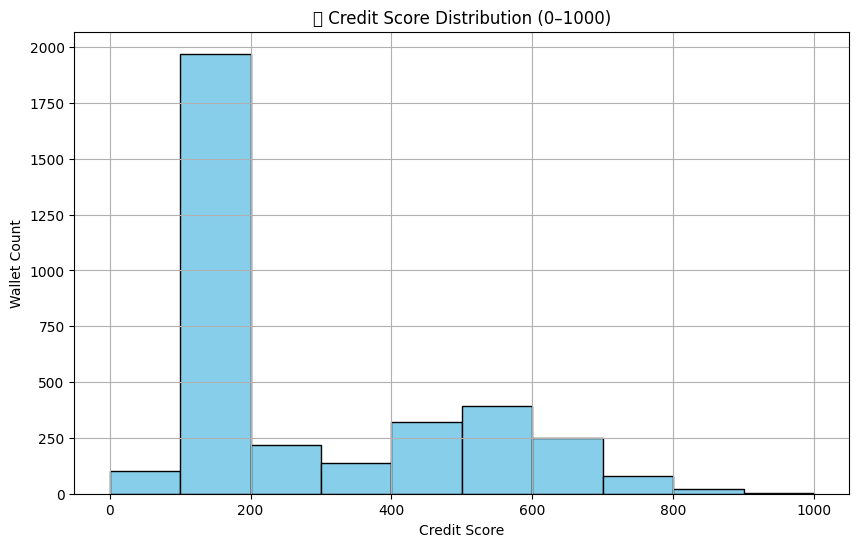

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
features['credit_score'].hist(bins=10, color='skyblue', edgecolor='black')
plt.title("📊 Credit Score Distribution (0–1000)")
plt.xlabel("Credit Score")
plt.ylabel("Wallet Count")
plt.grid(True)
plt.show()


In [40]:
# Create buckets
features['score_bucket'] = pd.cut(features['credit_score'],
                                   bins=[0,100,200,300,400,500,600,700,800,900,1000],
                                   labels=['0-100','100-200','200-300','300-400','400-500',
                                           '500-600','600-700','700-800','800-900','900-1000'])

# Analyze liquidation, repay ratio, borrow-repay time by bucket
bucket_analysis = features.groupby('score_bucket').agg({
    'liquidation_count': 'mean',
    'repay_to_borrow_ratio': 'mean',
    'avg_borrow_repay_time': 'mean',
    'credit_score': 'count'
}).rename(columns={'credit_score': 'wallet_count'})

print(bucket_analysis)


              liquidation_count  repay_to_borrow_ratio  avg_borrow_repay_time  \
score_bucket                                                                    
0-100                       0.0               0.000000           0.000000e+00   
100-200                     0.0               0.000000           0.000000e+00   
200-300                     0.0               0.002965           3.343436e+04   
300-400                     0.0               0.067005           4.534270e+05   
400-500                     0.0               0.659907           7.362678e+05   
500-600                     0.0               0.825803           1.049599e+06   
600-700                     0.0               0.967898           1.964533e+06   
700-800                     0.0               0.945132           3.070423e+06   
800-900                     0.0               1.045455           3.441544e+06   
900-1000                    0.0               0.983812           3.000983e+06   

              wallet_count 

/tmp/ipython-input-40-3158185330.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_analysis = features.groupby('score_bucket').agg({


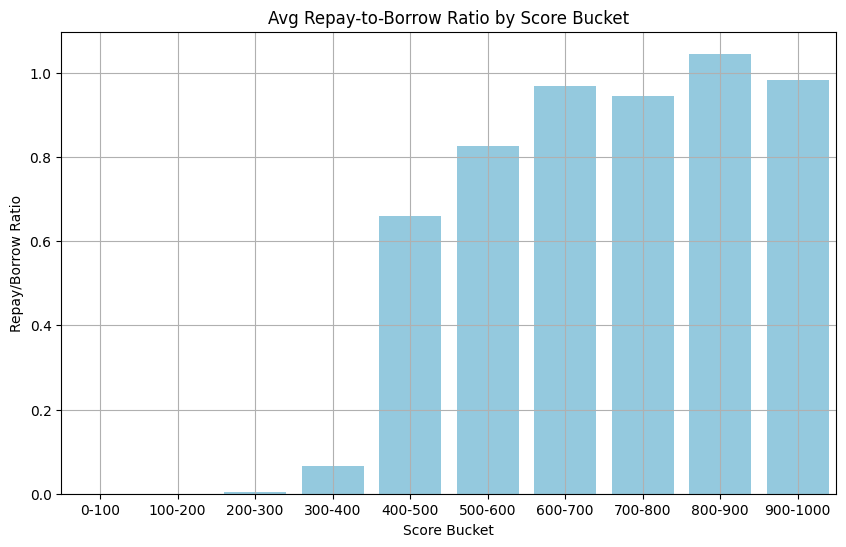

In [41]:
import seaborn as sns

# Repay-to-borrow ratio trend
plt.figure(figsize=(10,6))
sns.barplot(x=bucket_analysis.index, y=bucket_analysis['repay_to_borrow_ratio'], color='skyblue')
plt.title("Avg Repay-to-Borrow Ratio by Score Bucket")
plt.ylabel("Repay/Borrow Ratio")
plt.xlabel("Score Bucket")
plt.grid(True)
plt.show()

In [44]:
!mkdir -p project-root
!touch project-root/score_wallets.py


In [45]:
# Basic folder listing
!ls -R


.:
 analysis.md    README.md	   transactions.json
 notebooks      scores.csv	  'user-wallet-transactions (1).json'
 project-root   score_wallets.py   user-wallet-transactions.json

./notebooks:
2_feature_engineering.ipynb  Aave_V2_Wallet_Credit_Scoring_EDA.ipynb

./project-root:
score_wallets.py


In [48]:
import os

# Create notebook directory
os.makedirs("project-root/notebooks", exist_ok=True)

# Create empty notebook files
notebooks = [
    "Aave_V2_Wallet_Credit_Scoring_EDA.ipynb"
    "2_feature_engineering.ipynb",


]

for nb in notebooks:
    open(f"project-root/notebooks/{nb}", "a").close()

# Create missing root-level files if not already present
for filename in ["analysis.md", "scores.csv", "README.md"]:
    filepath = f"project-root/{filename}"
    if not os.path.exists(filepath):
        open(filepath, "a").close()

print("✅ Folder structure now complete.")


✅ Folder structure now complete.
